#### Importing packages

In [32]:
import random
import time
import pickle
import sys
import re
import string
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger


import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

## Fragebogen

#### Reading fragebogen information

In [2]:
fragebogen = pd.read_csv('./csv/fragebogen.csv', names=["id",
                                                        "nummer", 
                                                        "titel", 
                                                        "schlagwoerter", 
                                                        "erscheinungsjahr",
                                                        "autoren", 
                                                        "originaldaten",
                                                        "anmerkung",
                                                        "freigabe",
                                                        "checked",
                                                        "wordleiste",
                                                        "druck",
                                                        "online",
                                                        "publiziert",
                                                        "fragebogen_typ_id",])

fragebogen.drop(["id","schlagwoerter","erscheinungsjahr","autoren","originaldaten","anmerkung","freigabe",
                 "checked","wordleiste","druck","online","publiziert","fragebogen_typ_id",], inplace=True, axis=1)

fragebogen.set_index("nummer", drop=True, inplace=True)

In [3]:
fragebogen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, 1 to ETir.28
Data columns (total 1 columns):
titel    762 non-null object
dtypes: object(1)
memory usage: 11.9+ KB


In [4]:
fragebogen.head()

,titel
nummer,
1,Fragebogen 1: Kopf (1)
2,Fragebogen 2: Die Osterwoche (1)
3,Fragebogen 3: Die Osterwoche (2)
4,Fragebogen 4: Kopf (2)
5,Fragebogen 5: Zeit zwischen Ostern und Fronlei...


#### Filtering the original fragebogen

In [5]:
fragebogen.tail()

,titel
nummer,
ETir.24,24. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.25,25. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.26,26. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.27,27. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.28,28. Ergänzungsfragebogen zum Tiroler Fragebuch


In [6]:
fragebogen[fragebogen.titel.str.startswith('Fragebogen')].tail()

,titel
nummer,
105,Fragebogen 105: Verkehr
106,Fragebogen 106: Wasser
107,Fragebogen 107: Gewerbe
108,Fragebogen 108: Gewerbe
109,Fragebogen 109: Gewerbe


In [7]:
fb_original = fragebogen[fragebogen.titel.str.startswith('Fragebogen')]

#### Extracting information from the fragebogen titel

In [8]:
regex1 = r'([Fragebon]+)\s{1}([0-9]+)[:]{1}([,A-ZÄÖÜa-zäöüß0-9.\s]+)[,\s]*([=\-\(\)\sA-ZÄÖÜa-zäöüß0-9]*)'

fb_original.titel.str.extract(regex1).head()
#fb_original.titel.str.extract(regex1).tail()

,0,1,2,3
nummer,,,,
1,Fragebogen,1,Kopf,(1)
2,Fragebogen,2,Die Osterwoche,(1)
3,Fragebogen,3,Die Osterwoche,(2)
4,Fragebogen,4,Kopf,(2)
5,Fragebogen,5,Zeit zwischen Ostern und Fronleichnam,


In [9]:
my_stopwords = set(["i", "ii"])
german_stopwords = set(stopwords.words('german')).union(my_stopwords)

In [10]:
#https://stackoverflow.com/questions/35231285/python-how-to-split-a-string-by-non-alpha-characters

def tokenize_and_clean(input):
    output = re.findall(r'\w+',input)
    output = [elem.strip(string.punctuation).title() for elem in output]
    output = [elem for elem in output if (elem.lower() not in german_stopwords)]
    output = [elem for elem in output if not elem.isnumeric()]
    return output

In [11]:
fb_original['number'] = fb_original.titel.str.extract(regex1)[1].str.strip()
fb_original['headwords'] = fb_original.titel.str.extract(regex1)[2].str.strip()
fb_original['headwords_list'] = fb_original.headwords.apply(tokenize_and_clean)
fb_original['series'] = fb_original.titel.str.extract(regex1)[3].str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [12]:
fb_original.head(30)

,titel,number,headwords,headwords_list,series
nummer,,,,,
1,Fragebogen 1: Kopf (1),1,Kopf,[Kopf],(1)
2,Fragebogen 2: Die Osterwoche (1),2,Die Osterwoche,[Osterwoche],(1)
3,Fragebogen 3: Die Osterwoche (2),3,Die Osterwoche,[Osterwoche],(2)
4,Fragebogen 4: Kopf (2),4,Kopf,[Kopf],(2)
5,Fragebogen 5: Zeit zwischen Ostern und Fronlei...,5,Zeit zwischen Ostern und Fronleichnam,"[Zeit, Ostern, Fronleichnam]",
6,Fragebogen 6: Menschl. Haar und Bart (= Kopf 3),6,Menschl. Haar und Bart,"[Menschl, Haar, Bart]",(= Kopf 3)
7,Fragebogen 7: Hochzeit (1),7,Hochzeit,[Hochzeit],(1)
8,Fragebogen 8: Hochzeit (2),8,Hochzeit,[Hochzeit],(2)
9,Fragebogen 9: Hochzeit (3),9,Hochzeit,[Hochzeit],(3)


In [13]:
#print(fb_original.index)
print(fb_original.number.unique())
print()
print(fb_original.headwords.unique())
print()
print(fb_original.series.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109']

['Kopf' 'Die Osterwoche' 'Zeit zwischen Ostern und Fronleichnam'
 'Menschl. Haar und Bart' 'Hochzeit' 'Nase, Ohr' 'Auge'
 'Besiedelung, Flur' 'Feld, Feldbestellung' 'Körper' 'Körperteile'
 'Hautkrankheiten' 'Brotbacken' 'Weißgebäck' 'Gliedmaßen, Arm' 'Arm'
 'Hand' 'Finger' 'Schneiderei' 'Kleidung' 'Bewegung' 'Farbe'
 'Zeit zwischen Mittsommer und Neujahr' 'Tod'
 'Gruß, Wunsch, Bitte und Dank' 'Jagd' 'Wald und Forstwirtschaft' 'Tiere'
 'Kind

In [14]:
fb_original.groupby("headwords")["number"].apply(lambda group_series: group_series.tolist()).reset_index().head(10)

,headwords,number
0,1. Erdoberfläche,[104]
1,Arm,[33]
2,Auge,[13]
3,"Besiedelung, Flur","[14, 15]"
4,Bewegung,"[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]"
5,Bierbrauerei,[101]
6,"Blutsverwandtschaft, Altersstufen",[87]
7,Brotbacken,"[28, 29, 30]"
8,Das Pferd,[76]
9,Der Bauernhof,"[92, 93]"


In [15]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.number:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'number'], length = 10)

In [16]:
#print(G.nodes)
print(G.edges)

[('Kopf', '1'), ('Kopf', '4'), ('Osterwoche', '2'), ('Osterwoche', '3'), ('Zeit', '5'), ('Zeit', '54'), ('Zeit', '68'), ('Zeit', '72'), ('Ostern', '5'), ('Ostern', '72'), ('Fronleichnam', '5'), ('Menschl', '6'), ('Haar', '6'), ('Bart', '6'), ('Hochzeit', '7'), ('Hochzeit', '8'), ('Hochzeit', '9'), ('Hochzeit', '10'), ('Hochzeit', '11'), ('Nase', '12'), ('Ohr', '12'), ('Auge', '13'), ('Besiedelung', '14'), ('Besiedelung', '15'), ('Flur', '14'), ('Flur', '15'), ('Feld', '16'), ('Feld', '17'), ('Feld', '18'), ('Feld', '19'), ('Feldbestellung', '16'), ('Feldbestellung', '17'), ('Feldbestellung', '18'), ('Feldbestellung', '19'), ('Körper', '20'), ('Körper', '21'), ('Körper', '22'), ('Körper', '23'), ('Körperteile', '24'), ('Körperteile', '77'), ('Körperteile', '78'), ('Hautkrankheiten', '25'), ('Hautkrankheiten', '26'), ('Hautkrankheiten', '27'), ('Brotbacken', '28'), ('Brotbacken', '29'), ('Brotbacken', '30'), ('Weißgebäck', '31'), ('Gliedmaßen', '32'), ('Arm', '32'), ('Arm', '33'), ('Hand

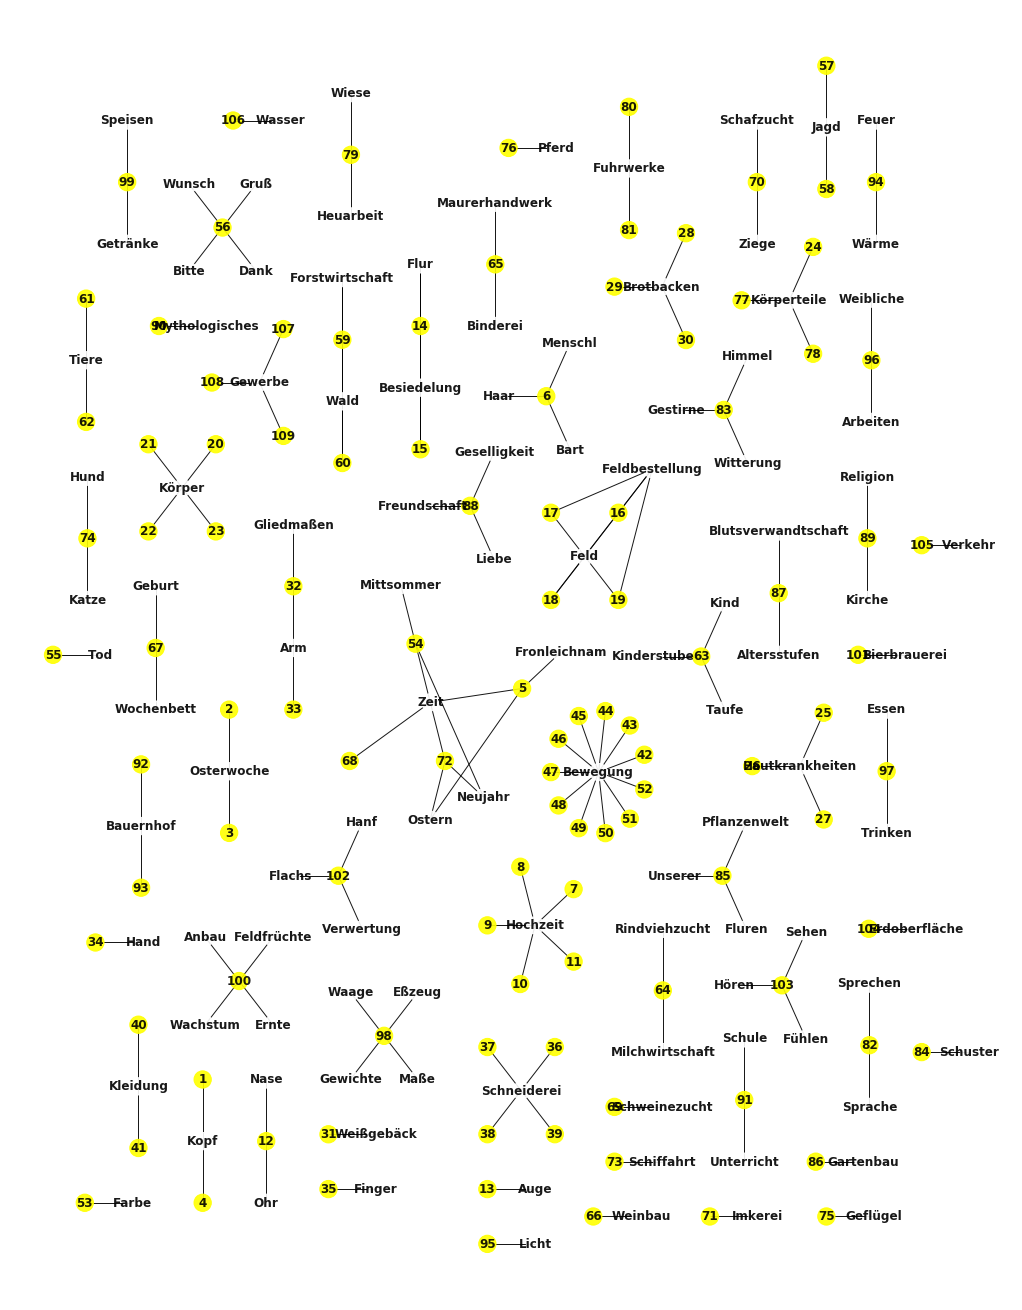

In [17]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph

plt.figure(figsize=(14,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        font_weight='bold', 
        #font_color='white',
       )


plt.show()

## Frage

#### Reading frage information

In [18]:
frage = pd.read_csv('./csv/frage.csv', names=["id", "fragebogen_id","nummer", "original_frage", "kurzfrage", "originaldaten"])

In [19]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24382 entries, 0 to 24381
Data columns (total 6 columns):
id                24382 non-null int64
fragebogen_id     24382 non-null int64
nummer            24382 non-null object
original_frage    24382 non-null object
kurzfrage         17413 non-null object
originaldaten     6528 non-null object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Filtering the relevant collumns and the original questionnaires

In [20]:
frage.drop(["id", "originaldaten", "kurzfrage"], axis=1, inplace=True)
frage = frage[frage.fragebogen_id <= 109]
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 0 to 16743
Data columns (total 3 columns):
fragebogen_id     16744 non-null int64
nummer            16744 non-null object
original_frage    16744 non-null object
dtypes: int64(1), object(2)
memory usage: 523.2+ KB


In [21]:
frage.head()

,fragebogen_id,nummer,original_frage
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr."
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ..."
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf"


In [22]:
frage.tail()

,fragebogen_id,nummer,original_frage
16739,109,602,Gewerbe: (Gehalts-)Zulage
16740,109,603,"Gewerbe: Abzug v. Gehalt, Pl."
16741,109,604,"Gewerbe: sonstige heute noch lebende, bodenstä..."
16742,109,605,"Gewerbe: abgekommene, bodenständige Berufe, di..."
16743,109,606,"Gewerbe: bodenständige FN, die vermutl. auf ei..."


#### Extracting information from the frage "original_frage" field

In [23]:
regex2 = r'([A-ZÄÖÜa-zäöüß.\(\)\-\/]+)[:]{1}([A-ZÄÖÜa-zäöüß0-9=,;:\-\(\)\.\?\s]+)'

frage.original_frage.str.extract(regex2).head(10)

,0,1
0,Kopf,"Kopf, Haupt; auch scherzh."
1,Kopf,Kopf
2,Kopf,Kopf
3,Kopf,"schöner, ebenmäßig gebauter Kopf (Christuskop..."
4,Kopf,"häßlicher, unebenmäßiger Kopf"
5,Kopf,großer Kopf; großkopfig
6,Kopf,Wasserkopf
7,Kopf,kleiner Kopf
8,Kopf,oben zugespitzter Kopf
9,Kopf,langer Kopf


In [24]:
frage['main_theme'] = frage.original_frage.str.extract(regex2)[0]
frage[frage['main_theme'].isna()]
#frage['main_theme'].value_counts()

,fragebogen_id,nummer,original_frage,main_theme
3605,41,E,siehe 67E (Ergänzungen),NaN
3606,41,F,siehe 67F (Ergänzungen),NaN
3607,41,E,im Fragebuch Ergänzung unter 67E,NaN
3608,41,F,im Fragebuch Ergänzung unter 67F,NaN
9125,69,C,"Körperteile des Schweines, soweit von Rind/Wil...",NaN
9135,69,D,Lebensäußerungen des Schweines,NaN


In [25]:
frage['main_theme'] = frage.original_frage.str.extract(regex2)[0]
frage.dropna(subset=['main_theme'], inplace=True,)
frage['main_theme'] = frage['main_theme'].apply(tokenize_and_clean)

frage['question_words'] = frage.original_frage.str.extract(regex2)[1].str.strip()
frage['question_words'] = frage.question_words.apply(tokenize_and_clean)

concepts = []
for i in frage.index:
    a = frage.loc[i,'main_theme']
    b = frage.loc[i, 'question_words']
    concepts.append(list(set(a+b)))

frage['question_words'] = concepts

frage.head(20)
#frage.info()

,fragebogen_id,nummer,original_frage,main_theme,question_words
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr.",[Kopf],"[Scherzh, Kopf, Haupt]"
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...,[Kopf],[Kopf]
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...,[Kopf],[Kopf]
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ...",[Kopf],"[Kopf, Schöner, Tituskopf, Gebauter, Christusk..."
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf",[Kopf],"[Unebenmäßiger, Kopf, Häßlicher]"
5,1,A5,Kopf: großer Kopf; großkopfig,[Kopf],"[Großer, Großkopfig, Kopf]"
6,1,A5a,Kopf: Wasserkopf,[Kopf],"[Wasserkopf, Kopf]"
7,1,A6,Kopf: kleiner Kopf,[Kopf],"[Kleiner, Kopf]"
8,1,A7,Kopf: oben zugespitzter Kopf,[Kopf],"[Oben, Kopf, Zugespitzter]"
9,1,A8,Kopf: langer Kopf,[Kopf],"[Langer, Kopf]"


#### Examining the common concepts

In [26]:
concepts = []
#for entry in frage.question_words.values:
for entry in frage.original_frage.values:    
    for concept in entry.split():
        concepts.append(concept)
concepts = [c for c in concepts if c not in german_stopwords]
concepts = collections.Counter(concepts)
concepts.most_common(40)

[('wie:', 1929),
 ('d.', 1546),
 ('Komp.', 1471),
 ('m.', 1423),
 ('Ra.', 1137),
 ('z.B.', 841),
 ('u.', 805),
 ('Gewerbe:', 607),
 ('(=', 381),
 ('u.a.', 379),
 ('f.', 367),
 ('v.', 363),
 ('Ausdrücke', 259),
 ('od.', 244),
 ('Bed.', 236),
 ('Pl.,', 233),
 ('Bez.', 203),
 ('Schneiderei:', 198),
 ('Kopf:', 191),
 ('bes.', 182),
 ('sonstige', 171),
 ('=', 168),
 ('Eisenbahn:', 168),
 ('(auch', 162),
 ('Pl./Dem.;', 160),
 ('(z.B.', 159),
 ('usw.', 157),
 ('beim', 155),
 ('Abl.', 149),
 ('Dem.,', 149),
 ('Vb.', 148),
 ('Auge:', 136),
 ('z.', 134),
 ('u.ä.', 134),
 ('Teile', 129),
 ('Hautkrankh.:', 127),
 ('Gewässer:', 122),
 ('besondere', 121),
 ('Vögel:', 120),
 ('aus-,', 118)]

#### Working with abbreviations

#### finding Lemmas for each concept

In [27]:
#https://github.com/WZBSocialScienceCenter/germalemma
#https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/
#https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/
from germalemma import GermaLemma

#### Strategy 1 - [training a classifier with the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [44]:
#https://github.com/ptnplanet/NLTK-Contributions/blob/master/ClassifierBasedGermanTagger/ClassifierBasedGermanTagger.py

class ClassifierBasedGermanTagger(ClassifierBasedTagger):
    """A classifier based German part-of-speech tagger. It has an accuracy of
    96.09% after being trained on 90% of the German TIGER corpus. The tagger
    extends the NLTK ClassifierBasedTagger and implements a slightly modified
    feature detector.
    """

    def feature_detector(self, tokens, index, history):
        """Implementing a slightly modified feature detector.
        @param tokens: The tokens from the sentence to tag.
        @param index: The current token index to tag.
        @param history: The previous tagged tokens.
        """

        word = tokens[index]
        if index == 0: # At the beginning of the sentence
            prevword = prevprevword = None
            prevtag = prevprevtag = None
            #word = word.lower() # Lowercase at the beginning of sentence
        elif index == 1:
            prevword = tokens[index-1] # Note: no lowercase
            prevprevword = None
            prevtag = history[index-1]
            prevprevtag = None
        else:
            prevword = tokens[index-1]
            prevprevword = tokens[index-2]
            prevtag = history[index-1]
            prevprevtag = history[index-2]

        if re.match('[0-9]+([\.,][0-9]*)?|[0-9]*[\.,][0-9]+$', word):
            # Included "," as decimal point
            shape = 'number'
        elif re.compile('\W+$', re.UNICODE).match(word):
            # Included unicode flag
            shape = 'punct'
        elif re.match('([A-ZÄÖÜ]+[a-zäöüß]*-?)+$', word):
            # Included dash for dashed words and umlauts
            shape = 'upcase'
        elif re.match('[a-zäöüß]+', word):
            # Included umlauts
            shape = 'downcase'
        elif re.compile("\w+", re.UNICODE).match(word):
            # Included unicode flag
            shape = 'mixedcase'
        else:
            shape = 'other'

        features = {
            'prevtag': prevtag,
            'prevprevtag': prevprevtag,
            'word': word,
            'word.lower': word.lower(),
            'suffix3': word.lower()[-3:],
            #'suffix2': word.lower()[-2:],
            #'suffix1': word.lower()[-1:],
            'preffix1': word[:1], # included
            'prevprevword': prevprevword,
            'prevword': prevword,
            'prevtag+word': '%s+%s' % (prevtag, word),
            'prevprevtag+word': '%s+%s' % (prevprevtag, word),
            'prevword+word': '%s+%s' % (prevword, word),
            'shape': shape
            }
        return features

In [45]:
corp = nltk.corpus.ConllCorpusReader('./nlp/', 
                                     'tiger_release_aug07.corrected.16012013.conll09',
                                     ['ignore', 'words', 'ignore', 'ignore', 'pos'],
                                     encoding='utf-8')

In [46]:
tagged_sents = list(corp.tagged_sents())
random.shuffle(tagged_sents)

In [47]:
# set a split size: use 90% for training, 10% for testing
split_perc = 0.1
split_size = int(len(tagged_sents) * split_perc)
train_sents, test_sents = tagged_sents[split_size:], tagged_sents[:split_size]

In [50]:
tagger = ClassifierBasedGermanTagger(train=train_sents)

In [51]:
accuracy = tagger.evaluate(test_sents)
tagger.tag(['Das', 'ist', 'ein', 'einfacher', 'Test'])

[('Das', 'ART'),
 ('ist', 'VAFIN'),
 ('ein', 'ART'),
 ('einfacher', 'ADJA'),
 ('Test', 'NN')]

In [72]:
tagger.tag(['Das'])[0][1]

'ART'

#### Training with all sentences

In [57]:
tagger = ClassifierBasedGermanTagger(train=tagged_sents)

In [58]:
with open('./nlp/nltk_german_classifier_data.pickle', 'wb') as f:
    pickle.dump(tagger, f, protocol=2)

In [59]:
with open('./nlp/nltk_german_classifier_data.pickle', 'rb') as f:
    tagger = pickle.load(f)

#### Strategy 2 - [Reading the Lemmata from the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [60]:
def read_lemmata_from_tiger_corpus(tiger_corpus_file, valid_cols_n=15, col_words=1, col_lemmata=2):
    lemmata_mapping = {}

    with open(tiger_corpus_file) as f:
        for line in f:
            parts = line.split()
            if len(parts) == valid_cols_n:
                w, lemma = parts[col_words], parts[col_lemmata]
                if w != lemma and w not in lemmata_mapping and not lemma.startswith('--'):
                    lemmata_mapping[w] = lemma

    return lemmata_mapping

lemmata_mapping = read_lemmata_from_tiger_corpus('./nlp/tiger_release_aug07.corrected.16012013.conll09')

In [61]:
lemmata_mapping['Das']

'der'

Using [hunspell](https://stackoverflow.com/questions/53029568/how-do-i-install-hunspell-python-package) for a fallback [option](https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/)

In [62]:
import hunspell

spellchecker = hunspell.HunSpell('./nlp/de_DE.dic','./nlp/de_DE.aff')
spellchecker_enc = spellchecker.get_dic_encoding()

In [63]:
def return_lemma(word, mapping):
    w_lemma = mapping.get(word, None)
    if not w_lemma:
        lemmata_hunspell = spellchecker.stem(word)
        if lemmata_hunspell:
            w_lemma = lemmata_hunspell[-1].decode(spellchecker_enc)

    if w_lemma:
        return(w_lemma)
    else:
        return(word)

In [64]:
return_lemma('Das', lemmata_mapping)

'der'

#### Strategy 3 - [If we have the POS, we can use the German Lemmatizer](https://github.com/WZBSocialScienceCenter/germalemma)

lemmatizer = GermaLemma()

In [ ]:
# passing the word and the POS tag ("N" for noun)

def return_lemma2(word):
    pos = tagger.tag([word])[0][1]
    lemma = lemmatizer.find_lemma('Feinstaubbelastungen', 'N')
    return(lemma)

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [ ]:
filtered = frage[frage.fragebogen_id <= 2]

In [ ]:
G = nx.Graph()

for concept_list in filtered.question_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'question_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

In [ ]:
plt.figure(figsize=(28,28))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        #font_weight='bold', 
        #font_color='white',
       )


plt.show()